In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git config --global user.name "TomasVDDC"
!git config --global user.email "tomasvddc@gmail.com"

In [2]:
%cd "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv"






/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv


In [ ]:
!git add .
!git commit -m "added notebook"
!git push

In [4]:
!pip install -U git+https://github.com/jlcsilva/segmentation_models.pytorch
!pip install -U albumentations

  Cloning https://github.com/jlcsilva/segmentation_models.pytorch to /tmp/pip-req-build-lba150ni
  Running command git clone --filter=blob:none --quiet https://github.com/jlcsilva/segmentation_models.pytorch /tmp/pip-req-build-lba150ni
  Resolved https://github.com/jlcsilva/segmentation_models.pytorch to commit 44a5593bfb1c8f2a3f5f23303c02e6f7e2f11170
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 9.4 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-py3-none-any.whl size=96317 sha256=f4dfe55058ef74b94da3fdf72e9425e2fdaaed13cb406a7f6bfec490c2a95c23
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgche1my/wheels/62/8f/61/617a3d940a6f738b4e551b3e97729743fd1ee4892d5ad65c44
  Created wheel for efficientnet-pytorch: f

In [5]:

%matplotlib inline
import segmentation_models_pytorch as smp
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu


In [6]:
# Helper functions


def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

In [7]:
img_example = load_image("./data/training/images/satImage_001.png")
print("Dimension of each image is {}".format(img_example.shape)) #rank 3 tensor with the depth axis being rgb

names_of_images = os.listdir("./data/training/images/")
images = np.array([load_image("./data/training/images/{}".format(names_of_images[i])) for i in range(100)])
print("Dimension of image tensor is {}".format(images.shape))



Dimension of each image is (400, 400, 3)


IndexError: ignored

In [ ]:
ground_truth_example = load_image("./data/training/groundtruth/satImage_001.png")
print("Dimension of each image is {}".format(ground_truth_example.shape)) #rank 3 tensor with the depth axis being rgb
print(ground_truth_example[:1])
names_of_ground_truth = os.listdir("./data/training/groundtruth/")
ground_truths = np.array([load_image("./data/training/groundtruth/{}".format(names_of_ground_truth[i])) for i in range(100)])
print("Dimension of ground truth tensor is {}".format(ground_truths.shape))

Dimension of each image is (400, 400)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.00392157 0.         0.73333335 0.92941177 0.91764706 0.92941177
  0.92941177 0.92941177 0.92941177 0.92941177 0.92941177 0.92156863
  0.92941177 0.81960785 0.01568628 0.         0.00392157 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         

IndexError: ignored

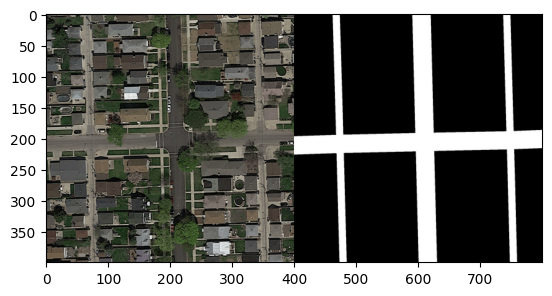

In [ ]:
img_pair_example = concatenate_images(img_example, ground_truth_example)
plt.imshow(img_pair_example)

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset


In [9]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = [ 'road', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #try using 416 pixels
        mask = cv2.imread(self.masks_fps[i],0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

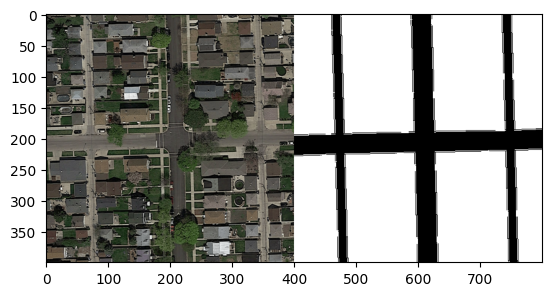

In [ ]:
# Lets look at data we have

dataset = Dataset("./data/training/images", "./data/training/groundtruth", classes=['road'])

image, mask = dataset[0] # get some sample
img_pair = concatenate_images(image, mask.squeeze())
plt.imshow(img_pair)

In [10]:
ENCODER = 'resnet50'  #test with 34
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [11]:

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [12]:
train_dataset = Dataset(
    "./data/training/images",
    "./data/training/groundtruth",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)

valid_dataset = Dataset(
    "./data/validation/images",
    "./data/validation/groundtruth",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [14]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [15]:
# train model for 15 epochs (had to interrupt forgot tp change range in for loop)

max_score = 0
train_loss_array = []
validation_loss_array = []

for i in range(0, 15):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    train_loss_array.append(train_logs["dice_loss"])
    validation_loss_array.append(valid_logs["dice_loss"])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, dice_loss - 0.3815, iou_score - 0.5805]
Model saved!

Epoch: 1
valid: 100%|██████████| 20/20 [00:01<00:00, 10.76it/s, dice_loss - 0.2706, iou_score - 0.6798]
Model saved!

Epoch: 2
valid: 100%|██████████| 20/20 [00:01<00:00, 11.36it/s, dice_loss - 0.1855, iou_score - 0.7968]
Model saved!

Epoch: 3
valid: 100%|██████████| 20/20 [00:01<00:00, 12.28it/s, dice_loss - 0.1669, iou_score - 0.8212]
Model saved!

Epoch: 4
valid: 100%|██████████| 20/20 [00:01<00:00, 12.73it/s, dice_loss - 0.1282, iou_score - 0.8654]
Model saved!

Epoch: 5
valid: 100%|██████████| 20/20 [00:01<00:00, 12.34it/s, dice_loss - 0.1238, iou_score - 0.8663]
Model saved!

Epoch: 6
valid: 100%|██████████| 20/20 [00:01<00:00, 12.20it/s, dice_loss - 0.1145, iou_score - 0.8809]
Model saved!

Epoch: 7
valid: 100%|██████████| 20/20 [00:01<00:00, 12.11it/s, dice_loss - 0.1142, iou_score - 0.8877]
Model saved!

Epoch: 8
valid: 100%|██████████| 20/20 [00:01<00:00, 12

KeyboardInterrupt: ignored

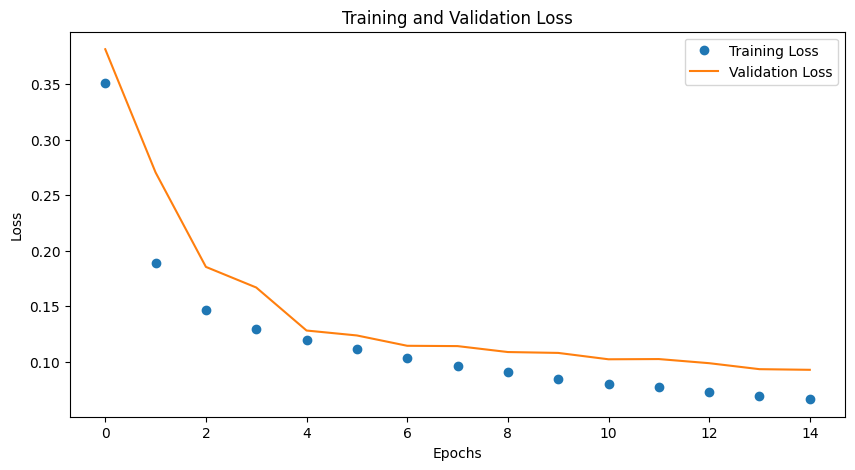

In [16]:
epochs = np.arange(0, 15)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_array[:15],"o", label='Training Loss')
plt.plot(epochs, validation_loss_array[:15],  label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# create test dataset
test_dataset = Dataset(
  "./data/test_set_images", "./data/test_set_images",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataset_vis = Dataset(
  "./data/test_set_images", "./data/test_set_images",
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset)

In [ ]:
""" # evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)  dont have groundtruth for those tests"""

valid: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s, dice_loss - 0.02767, iou_score - 0.9702]


In [ ]:
from PIL import Image


n = len(test_dataset)
best_model = torch.load('./best_model.pth')


for i in range(2):
    #n = np.random.choice(len(test_dataset))


    image, gt_mask = test_dataset[i]



    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    #pr_mask = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    pr_mask[pr_mask == 0] = -1     # Temporarily replace 0 with a placeholder (-1)
    pr_mask[pr_mask == 1] = 0      # Replace 1 with 0
    pr_mask[pr_mask == -1] = 1

    #pr_mask = cv2.resize(pr_mask, (600, 600), interpolation=cv2.INTER_AREA)

    cv2.imwrite('predictions/image_{}.png'.format(i), pr_mask)
    #print(pr_mask.shape,pr_mask[:1])
    #plt.imshow(pr_mask)
    #plt.savefig('predictions/image_{}.png'.format(i))#, bbox_inches='tight', pad_inches=0)


In [ ]:
from data.mask_to_submission import masks_to_submission

submission_filename = 'dummy_submission5.csv'
image_filenames = []
for i in range(50):
    image_filename = 'predictions/image_{}.png'.format(i)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

In [ ]:
import pandas as pd

img_example = load_image("./predictions/image_1.png")
print("Dimension of each image is {}".format(img_example.shape)) #rank 3 tensor with the depth axis being rgb

df = pd.read_csv("./dummy_submission5.csv")
len(df)

Dimension of each image is (608, 608)


72200

In [ ]:



for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())




    plt.figure(figsize=(15, 5))  # Set the figure size as needed

    # Display img1 in the first subplot
    plt.subplot(1, 3, 1)
    plt.imshow(image_vis)

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask)

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask)








Output hidden; open in https://colab.research.google.com to view.